In [1]:
import numpy as np
from pathlib import Path
from noise2inverse import tiffs, noise, fig
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
import tomosipo as ts
import tomopy
import tifffile
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

In [2]:
# Parameters
train_dir = Path("reconstructions")
output_dir = Path("weights")

num_splits = 4
strategy = "X:1"
epochs = 100
# NOTE: reduce the batch size to fit training in GPU memory for unet and dncnn
batch_size = 16
multi_gpu = True
network = "msd" # msd or unet or dncnn

# Scale pixel intensities during training such that its values roughly occupy the range [0,1].
# This improves convergence.
data_scaling = 200

In [3]:
datasets = [TiffDataset(train_dir / f"{j}/*.tif") for j in range(num_splits)]
train_ds = Noise2InverseDataset(*datasets, strategy=strategy)

train_ds.num_slices, train_ds.num_splits

(512, 4)

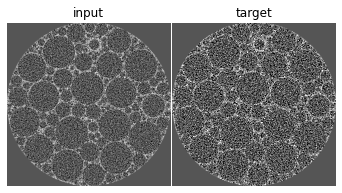

In [4]:
fig.plot_imgs(
    input=train_ds[0][0].detach().squeeze(),
    target=train_ds[0][1].detach().squeeze(),
    vmin=-0.004,
    vmax=0.008,
)

In [5]:
# Dataloader and network:
dl = DataLoader(train_ds, batch_size, shuffle=True,)

In [6]:
# Option a) Use MSD network
if network == "msd":
    from msd_pytorch import MSDRegressionModel
    model = MSDRegressionModel(1, 1, 100, 1, parallel=multi_gpu)
    net = model.net
    optim = model.optimizer

# Option b) Use UNet
if network == "unet":
    from noise2inverse import UNet
    net = UNet(1, 1).cuda() # 1 input channel, 1 output channel
    if multi_gpu:
        net = nn.DataParallel(net)

    optim = torch.optim.Adam(net.parameters())

# Option c) Use DnCNN
if network == "dncnn":
    from noise2inverse import DnCNN
    net = DnCNN(1).cuda() # 1 input channel, 1 output channel
    if multi_gpu:
        net = nn.DataParallel(net)

    optim = torch.optim.Adam(net.parameters())


In [7]:
output_dir.mkdir(exist_ok=True)

In [ ]:
# The dataset contains multiple input-target pairs for each slice. 
# Therefore, we divide by the number of splits to obtain the effective number of epochs.
train_epochs = max(epochs // num_splits, 1)

# training loop
for epoch in range(train_epochs):
    # Train
    for (inp, tgt) in tqdm(dl):
        inp = inp.cuda(non_blocking=True) * data_scaling
        tgt = tgt.cuda(non_blocking=True) * data_scaling

        # Do training step with masking
        output = net(inp)
        loss = nn.functional.mse_loss(output, tgt)
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Save network 
    torch.save(
        {"epoch": int(epoch), "state_dict": net.state_dict(), "optimizer": optim.state_dict()}, 
        output_dir / f"weights_epoch_{epoch}.torch"
    )
    
torch.save(
    {"epoch": int(epoch), "state_dict": net.state_dict(), "optimizer": optim.state_dict()}, 
    output_dir / "weights.torch"
)
